# Kaggle Competition - Network Science
*Predicting missing links in an actor co-occurrence network*

</br>

> Irene SUNNY

> Georgious MARKOU

> Robin WARROT

> Roshan VELPULA

In [1]:
import pandas as pd
import numpy as np

Imports from utils

In [2]:
from utils.dataprep import generate_samples, reduce_dimensions_sparse_tf_idf, feature_extractor, plot_lower_triangular_corr_matrix, prediction


Data Import

In [3]:
train_set = pd.read_csv('data/train.txt', sep=' ', header=None)
test_set = pd.read_csv('data/test.txt', sep=' ', header=None)

In [4]:
train_set = train_set.rename(columns={0 : 'source_id', 1:'target_id', 2: 'Link'})
test_set = test_set.rename(columns={0:'source_id', 1:'target_id'})

In [5]:
node_features = pd.read_csv('data/node_information.csv', header=None)


In [6]:
node_features = node_features.rename(columns={0 : 'node_id'})

In [7]:
sorted_nodes = list(node_features['node_id'].unique())

In [8]:
sorted_nodes.sort()

Node Mapping to have consistent and ordered node_id (Need it for GNNs)

In [9]:
node_mapping = {node_id: i for i, node_id in enumerate(sorted_nodes)}

In [10]:
# Step 2: Apply the mapping
node_features['node_id'] = node_features['node_id'].map(node_mapping)
train_set['source_id'] = train_set['source_id'].map(node_mapping)
train_set['target_id'] = train_set['target_id'].map(node_mapping)

In [11]:
test_set['source_id'] = test_set['source_id'].map(node_mapping)
test_set['target_id'] = test_set['target_id'].map(node_mapping)

In [12]:
test_set.columns

Index(['source_id', 'target_id'], dtype='object')

Sanity check for all nodes to be present in node_info

In [13]:
set_nodes_train = set(pd.unique(pd.concat([train_set['source_id'],train_set['target_id']])))
set_nodes_test = set(pd.unique(pd.concat([test_set['source_id'],test_set['target_id']])))
all_nodes = set_nodes_train.union(set_nodes_test)
set_node_feats = set(pd.unique(node_features.node_id))

# Convert to sets for easier comparison
set_all_nodes = set(all_nodes)
set_node_ids_in_features = set_node_feats

# Find missing node IDs
missing_node_ids = set_all_nodes - set_node_ids_in_features

# Check if there are any missing node IDs
if missing_node_ids:
    print(f"Missing node IDs in features: {missing_node_ids}")
else:
    print("All nodes in the train and test datasets have corresponding features.")


All nodes in the train and test datasets have corresponding features.


Creating a Graph

In [14]:
import networkx as nx
from community import community_louvain
from sklearn.model_selection import train_test_split


# Assuming train_set and node_features are already defined and preprocessed as per your previous code.
training_values = train_set.values.tolist()
edges = [(node_pair[0], node_pair[1]) for node_pair in training_values if node_pair[2] == 1]
# Create the graph from the edge list
G = nx.Graph()
G = G.to_undirected()

G.add_nodes_from(all_nodes)
G.add_edges_from(edges)

Node features sparsity check

In [15]:
kws_per_node = (node_features.drop(columns=['node_id'])
    .assign(kws = lambda df_: [sorted(set([col + 1 for col, val in enumerate(df_.loc[i]) if val != 0])) for i in df_.index])
    .kws.to_frame()
    .assign(num_kws = lambda df_: [len(kw) for kw in df_.kws])
)

kws_per_node.head(3)

,kws,num_kws
0,"[22, 24, 28, 29, 79, 92, 292, 522, 571, 705, 777]",11
1,"[56, 92, 93, 112, 139, 298, 522, 661]",8
2,"[93, 139, 571, 616]",4


In [16]:
nodes_per_kw = pd.DataFrame.from_dict(dict(node_features.drop(columns=['node_id']).sum().astype(int)), orient = "index", columns = ["num_nodes"])

nodes_per_kw.head(3)

,num_nodes
1,4
2,3
3,1


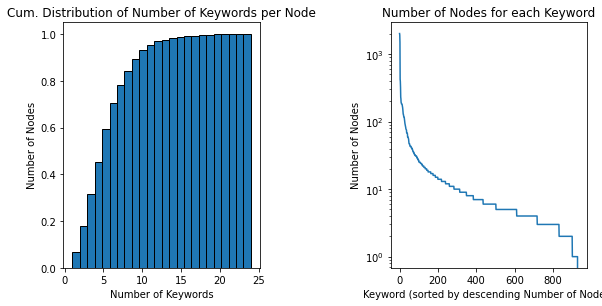

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize = (8, 4))
fig.tight_layout(w_pad = 10)

kws_per_node.num_kws.hist(ax = ax[0], bins = max(kws_per_node.num_kws), edgecolor="black", grid = False,
                          cumulative = True, density = 1)
ax[0].set_xlabel("Number of Keywords")
ax[0].set_ylabel("Number of Nodes")
ax[0].set_title("Cum. Distribution of Number of Keywords per Node")

nodes_per_kw.num_nodes.sort_values(ascending = False).plot(ax = ax[1], kind = "line", use_index = False)
ax[1].set_xlabel("Keyword (sorted by descending Number of Nodes)")
ax[1].set_ylabel("Number of Nodes")
ax[1].set_title("Number of Nodes for each Keyword")
ax[1].set_yscale("log")

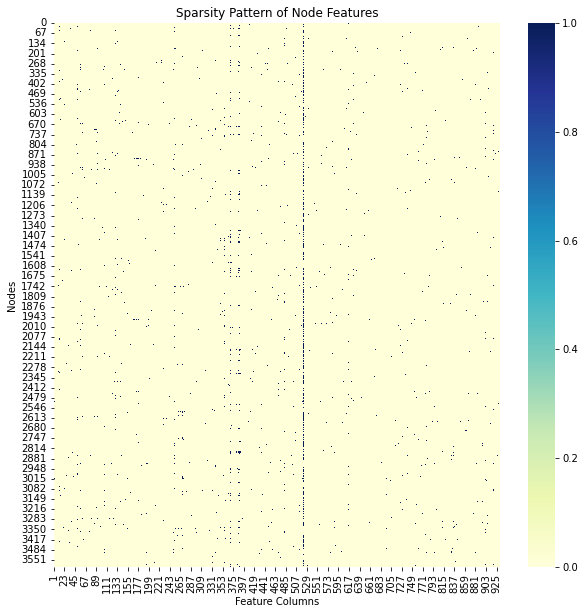

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns


# Dropping the 'node_id' column for the sparsity plot
features_only = node_features.drop(columns=['node_id'])

plt.figure(figsize=(10, 10))
sns.heatmap(features_only, cmap="YlGnBu", cbar=True)
plt.title('Sparsity Pattern of Node Features')
plt.xlabel('Feature Columns')
plt.ylabel('Nodes')
plt.show()

Creating reduced node features

In [19]:
reduced_features = reduce_dimensions_sparse_tf_idf(node_features.drop(['node_id'],axis=1).values)

Epoch [1/100], Loss: 0.0064
Epoch [2/100], Loss: 0.0064
Epoch [3/100], Loss: 0.0064
Epoch [4/100], Loss: 0.0063
Epoch [5/100], Loss: 0.0060
Epoch [6/100], Loss: 0.0058
Epoch [7/100], Loss: 0.0055
Epoch [8/100], Loss: 0.0050
Epoch [9/100], Loss: 0.0050
Epoch [10/100], Loss: 0.0049
Epoch [11/100], Loss: 0.0049
Epoch [12/100], Loss: 0.0049
Epoch [13/100], Loss: 0.0049
Epoch [14/100], Loss: 0.0048
Epoch [15/100], Loss: 0.0048
Epoch [16/100], Loss: 0.0047
Epoch [17/100], Loss: 0.0047
Epoch [18/100], Loss: 0.0046
Epoch [19/100], Loss: 0.0047
Epoch [20/100], Loss: 0.0047
Epoch [21/100], Loss: 0.0047
Epoch [22/100], Loss: 0.0047
Epoch [23/100], Loss: 0.0047
Epoch [24/100], Loss: 0.0047
Epoch [25/100], Loss: 0.0047
Epoch [26/100], Loss: 0.0046
Epoch [27/100], Loss: 0.0046
Epoch [28/100], Loss: 0.0046
Epoch [29/100], Loss: 0.0046
Epoch [30/100], Loss: 0.0046
Epoch [31/100], Loss: 0.0046
Epoch [32/100], Loss: 0.0046
Epoch [33/100], Loss: 0.0046
Epoch [34/100], Loss: 0.0045
Epoch [35/100], Loss: 0

Generating Train and Val Sets

In [20]:
np.random.seed(0)

In [21]:
residual_g, train_samples, train_labels, test_samples, test_labels = generate_samples(graph=G, train_set_ratio=0.8)

In [22]:
_, train_features_df = feature_extractor(G, residual_g, train_samples, reduced_features)
_, test_features_df = feature_extractor(G, residual_g, test_samples, reduced_features)

c:\Users\kingr\Downloads\M2 DSBA\MLNS\Kaggle\Github\utils\dataprep.py:385: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(train_graph, nodelist=nodelist)
100%|██████████| 8398/8398 [00:07<00:00, 1063.67it/s]
c:\Users\kingr\Downloads\M2 DSBA\MLNS\Kaggle\Github\utils\dataprep.py:385: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(train_graph, nodelist=nodelist)
100%|██████████| 2098/2098 [00:02<00:00, 998.88it/s] 


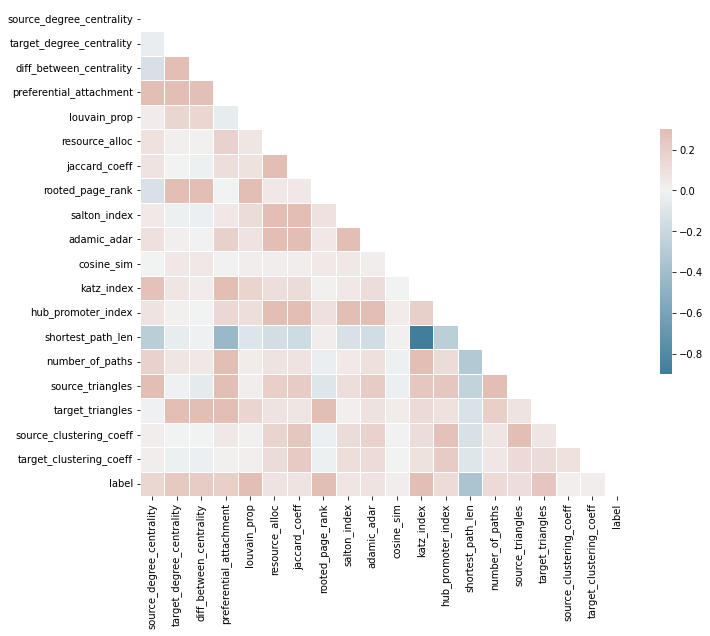

In [23]:
plot_lower_triangular_corr_matrix(train_features_df, train_labels)

Dropping higly correlated feature

In [24]:
train_features_df = train_features_df.drop(['shortest_path_len'],axis=1 )
test_features_df = test_features_df.drop(['shortest_path_len'],axis=1 )

In [25]:
# Check for NaN values
nan_columns = train_features_df.columns[train_features_df.isna().any()].tolist()

# Check for Inf values
inf_columns = train_features_df.columns[train_features_df.replace([np.inf, -np.inf], np.nan).isna().any()].tolist()

# Combine and get unique column names that have either NaN or Inf values
columns_with_issues = list(set(nan_columns + inf_columns))

print(f"Columns with NaN or Inf values: {columns_with_issues}")

Columns with NaN or Inf values: []


In [26]:
import warnings

warnings.filterwarnings('ignore')


Selected set of features from Feature selection notebook

In [33]:
feats = ['source_node', 'target_node','diff_between_centrality', 'source_triangles', 'preferential_attachment', 'source_degree_centrality', 'cosine_sim', 'salton_index', 'source_clustering_coeff', 'target_degree_centrality']

In [34]:
selected_train = train_features_df[feats]
selected_test = test_features_df[feats]

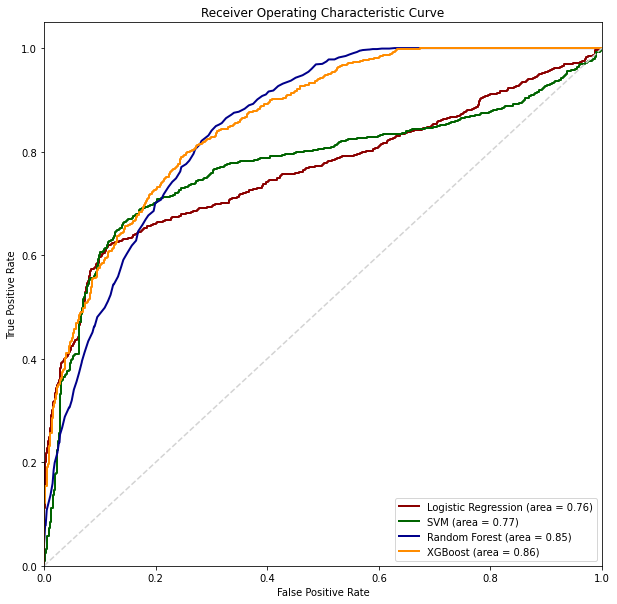

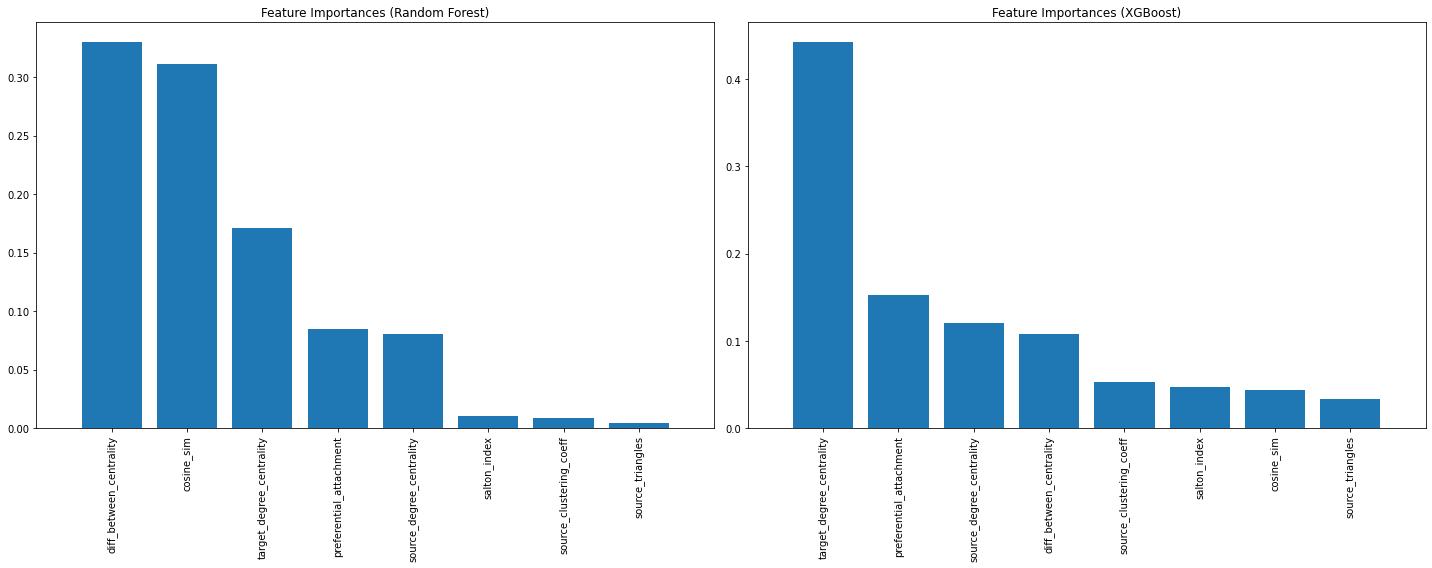

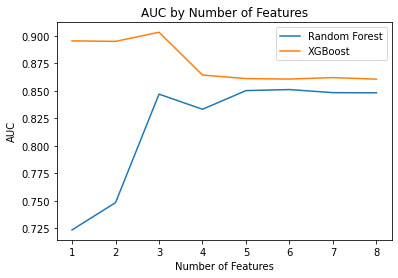

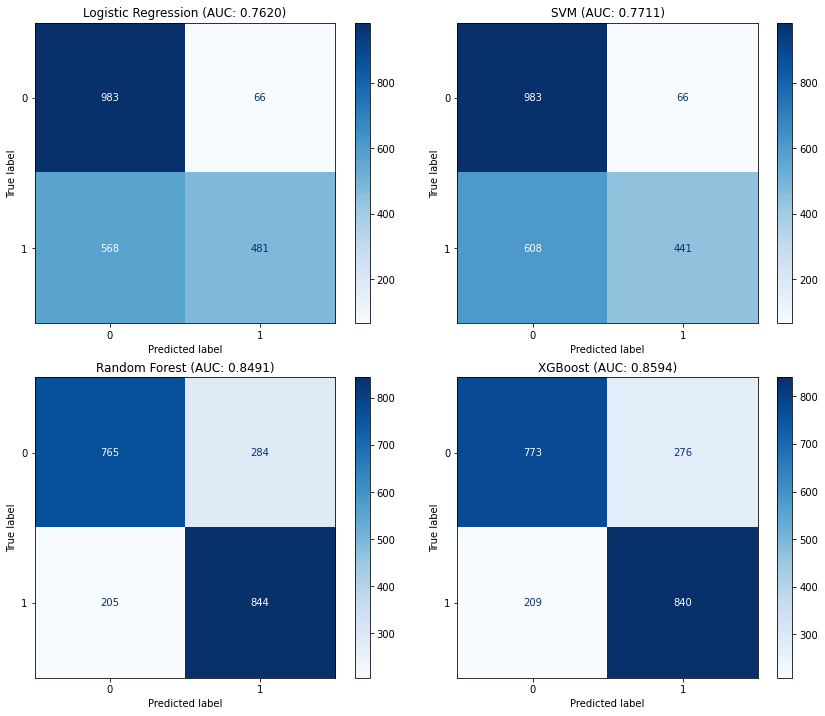

In [35]:
results = prediction(selected_train, selected_test, train_labels, test_labels)

In [37]:
features_xgb_rf = ['source_node', 'target_node','diff_between_centrality', 'preferential_attachment', 'source_degree_centrality', 'cosine_sim','target_degree_centrality']

In [38]:
selected_train = train_features_df[features_xgb_rf]
selected_test = test_features_df[features_xgb_rf]

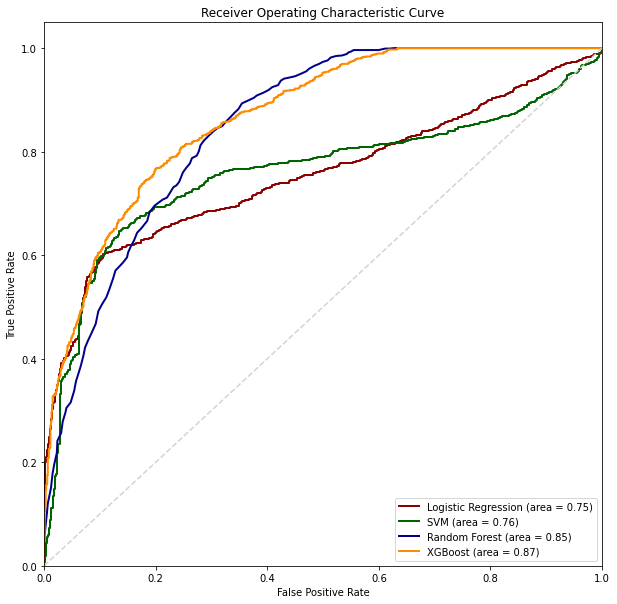

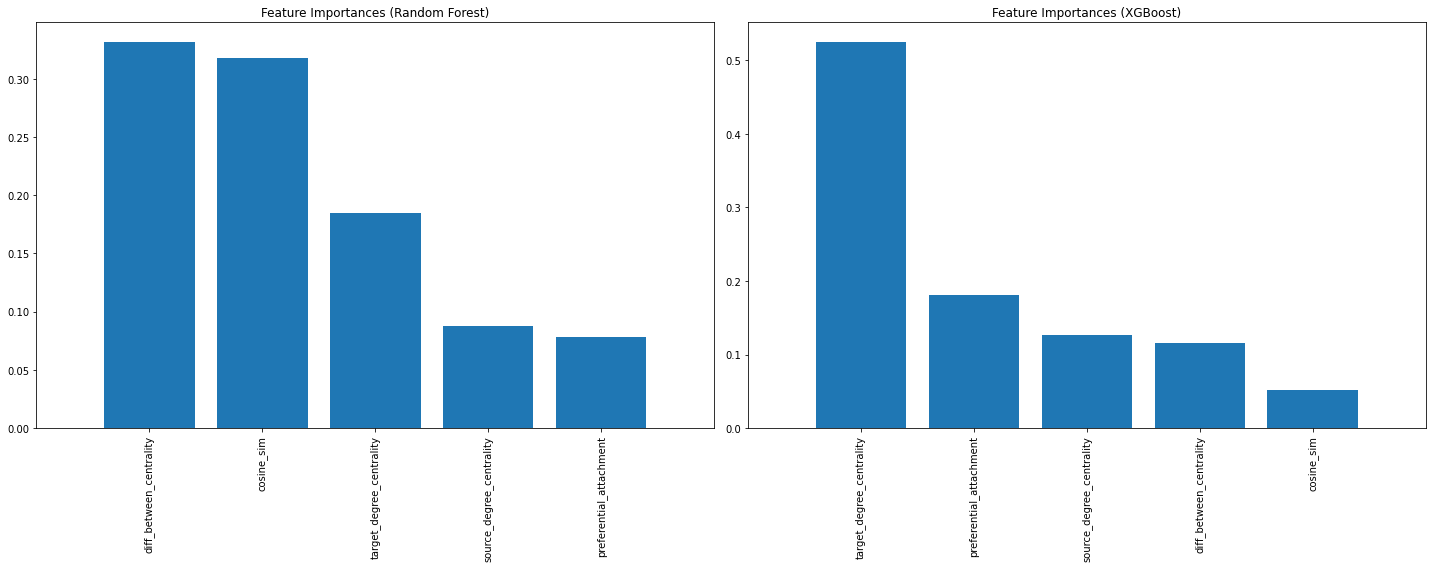

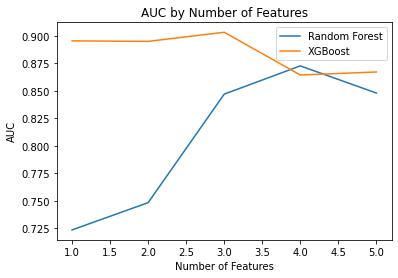

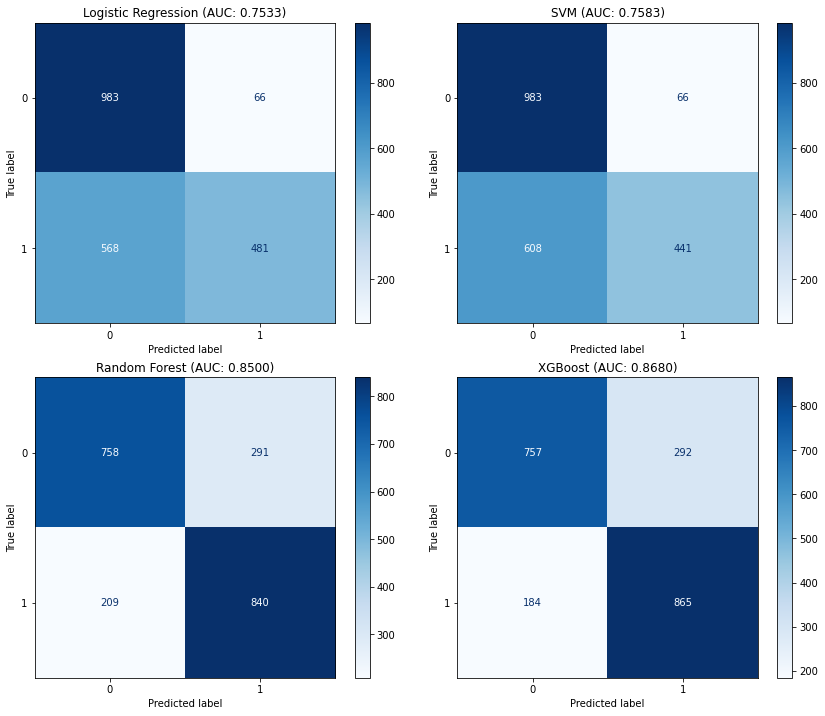

In [39]:
results = prediction(selected_train, selected_test, train_labels, test_labels)

Stacking

              precision    recall  f1-score   support

           0       0.79      0.75      0.77      1049
           1       0.77      0.81      0.79      1049

    accuracy                           0.78      2098
   macro avg       0.78      0.78      0.78      2098
weighted avg       0.78      0.78      0.78      2098

ROC AUC score: 0.8715859036842024


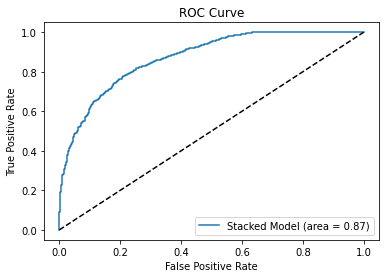

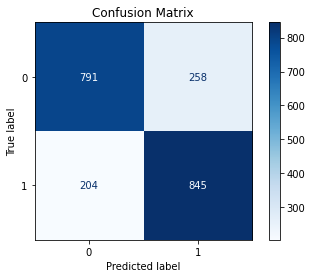

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier


# Define base learners
base_learners = [
    ('xgb_model', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)),
    ('lr_model', LogisticRegression(random_state=42)),
    
]

# Initialize Stacking Classifier with Logistic Regression as the meta-learner
stacked_model = StackingClassifier(estimators=base_learners, final_estimator=LogisticRegression(random_state=42))

X_train = selected_train.drop(['source_node','target_node'],axis=1)
X_test = selected_test.drop(['source_node','target_node'],axis=1)
# Fit the model
stacked_model.fit(X_train, train_labels)

# Make predictions
y_pred = stacked_model.predict(X_test)
y_pred_proba = stacked_model.predict_proba(X_test)[:, 1]


# Evaluate the model
print(classification_report(test_labels, y_pred))
roc_auc = roc_auc_score(test_labels, y_pred_proba)
print(f"ROC AUC score: {roc_auc}")


# Plot ROC curve
fpr, tpr, _ = roc_curve(test_labels, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label='Stacked Model (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Plot confusion matrix
cm = confusion_matrix(test_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


Submission

In [46]:
test_set = test_set[['source_id','target_id']]

In [47]:
sub_sample = [tuple(row) for row in test_set.values]

In [52]:
_,sub_features = feature_extractor(G, G, sub_sample,reduced_features)

100%|██████████| 3498/3498 [00:04<00:00, 854.01it/s]


In [53]:
sub_features = sub_features[features_xgb_rf]

In [54]:
sub_features = sub_features.drop(['source_node','target_node'],axis=1)

In [55]:
sub_preds_xgb = results['XGBoost']['classifier'].predict_proba(sub_features)[:, 1]

In [56]:
sub_preds_lr = results['Logistic Regression']['classifier'].predict_proba(sub_features)[:, 1]

In [57]:
sub_preds_svm = results['SVM']['classifier'].predict_proba(sub_features)[:, 1]

In [58]:
sub_preds_rf = results['Random Forest']['classifier'].predict_proba(sub_features)[:, 1]

In [59]:
sub_preds_stacked = stacked_model.predict_proba(sub_features)[:,1]

In [60]:
test_sub = test_set

In [61]:
test_sub['Predicted_xgb'] = sub_preds_xgb
test_sub['Predicted_lr'] = sub_preds_lr
test_sub['Predicted_svm'] = sub_preds_svm
test_sub['Predicted_rf'] = sub_preds_rf
test_sub['stacked_model'] = sub_preds_stacked

In [62]:
mask = (test_sub['source_id'] == test_sub['target_id'])

In [63]:
test_sub[mask]

,source_id,target_id,Predicted_xgb,Predicted_lr,Predicted_svm,Predicted_rf,stacked_model
220,2136,2136,0.000677,0.447903,0.506623,0.02,0.129057
457,1646,1646,0.000677,0.447903,0.506623,0.02,0.129057
575,319,319,0.975053,0.717830,0.892605,0.87,0.914671
743,2541,2541,0.000677,0.447903,0.506623,0.02,0.129057
1197,1144,1144,0.000677,0.447903,0.506623,0.02,0.129057
1415,2180,2180,0.975053,0.717830,0.892605,0.87,0.914671
1549,216,216,0.992888,0.873592,0.914010,0.87,0.941808
1608,2591,2591,0.999059,0.999847,0.864952,1.00,0.956340
1715,2505,2505,0.000677,0.447903,0.506623,0.02,0.129057
2433,2931,2931,0.000677,0.447903,0.506623,0.02,0.129057


In [64]:
test_sub['avg_preds'] = (test_sub['Predicted_xgb']  + test_sub['Predicted_lr'] + test_sub['stacked_model'] ) / 3

In [65]:
test_sub

,source_id,target_id,Predicted_xgb,Predicted_lr,Predicted_svm,Predicted_rf,stacked_model,avg_preds
0,1808,2330,0.081850,0.477499,0.599078,0.01,0.176983,0.245444
1,861,1398,0.563677,0.534354,0.741559,0.39,0.601257,0.566430
2,2465,3103,0.807374,0.478564,0.599093,0.99,0.770077,0.685338
3,2527,3492,0.697868,0.550479,0.741632,0.80,0.721872,0.656740
4,219,2743,0.076751,0.477704,0.599039,0.01,0.174257,0.242904
...,...,...,...,...,...,...,...,...
3493,832,1574,0.996644,1.000000,0.866699,1.00,0.955971,0.984205
3494,386,938,0.000577,0.443397,0.506603,0.00,0.127899,0.190624
3495,923,2072,0.998269,0.999999,0.865209,0.99,0.956229,0.984832
3496,235,600,0.676065,0.469597,0.599059,0.88,0.666502,0.604054


In [66]:
test_sub.loc[mask, 'avg_preds'] = 1

In [67]:
submission = test_sub['avg_preds'].reset_index()

In [68]:
submission = submission.rename(columns={'index': 'ID', 'avg_preds': 'Predicted'})

In [69]:
submission

,ID,Predicted
0,0,0.245444
1,1,0.566430
2,2,0.685338
3,3,0.656740
4,4,0.242904
...,...,...
3493,3493,0.984205
3494,3494,0.190624
3495,3495,0.984832
3496,3496,0.604054


In [70]:
submission.to_csv('data/submission_heuristics_xgb_svm_stacked_lr_avg.csv', index=False, header=True)